# Starbucks Deployment Data Analysis

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
from matplotlib import pyplot

import numpy as np 
import pandas as pd 
import os, sys

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from xgboost import XGBClassifier
from xgboost import plot_importance

## Load and visualize data


In [2]:
raw_data_path = os.path.join(os.environ["PWD"], '../dataset/deployments/starbucks', 'processed_data.csv')
df = pd.read_csv(raw_data_path)

fac = pd.factorize(df.iloc[:, 0].values) 
encoding = fac[0] 
symbols = fac[1]
y = symbols
# print(y)

Let's draw some example executions:

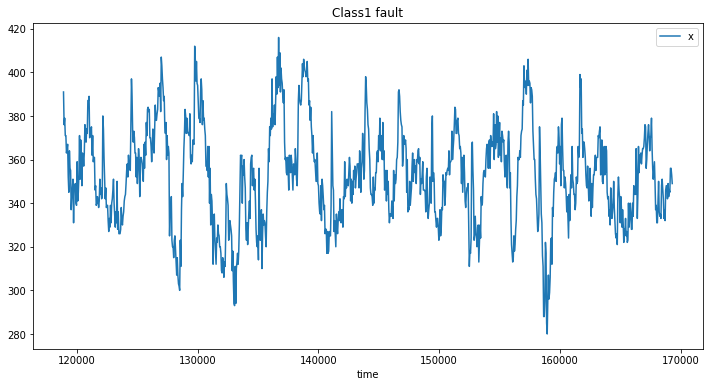

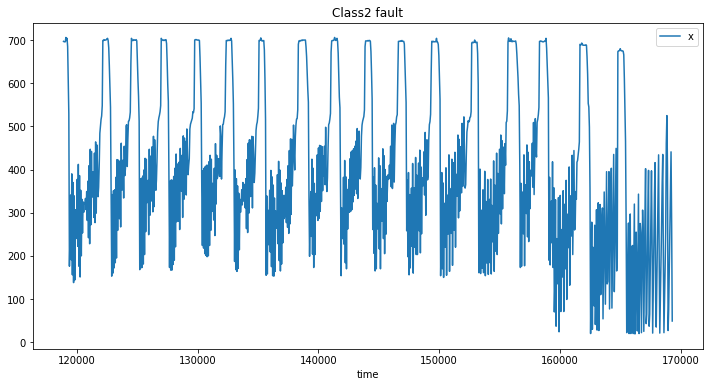

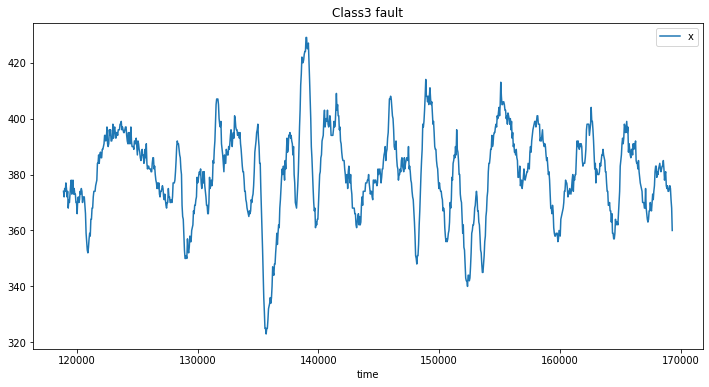

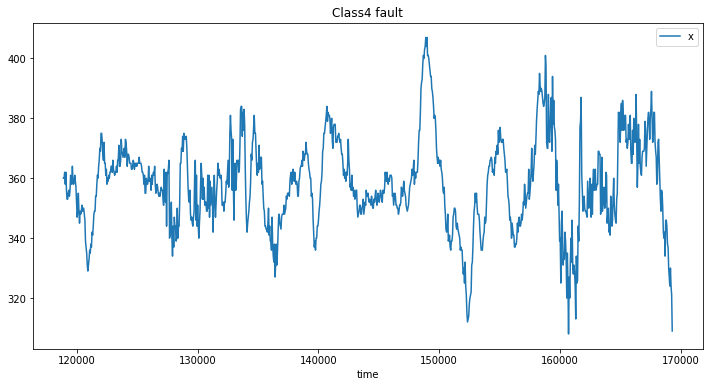

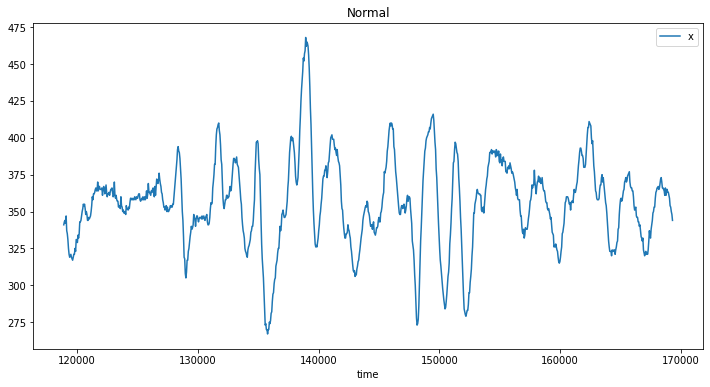

In [3]:
df[df.id == 'class1_1'][['time', 'x']].plot(x='time', title='Class1 fault', figsize=(12, 6));
df[df.id == 'class2_1'][['time', 'x']].plot(x='time', title='Class2 fault', figsize=(12, 6));
df[df.id == 'class3_1'][['time', 'x']].plot(x='time', title='Class3 fault', figsize=(12, 6));
df[df.id == 'class4_1'][['time', 'x']].plot(x='time', title='Class4 fault', figsize=(12, 6));
df[df.id == 'Normal_1'][['time', 'x']].plot(x='time', title='Normal', figsize=(12, 6));

## Extract Features

We can use the data to extract time series features using `tsfresh`.
We want to extract features for each time series, that means for each failure (which is our `id`) and for each of the measured Aout values.

The `time` column is our sorting column.

In [4]:
extraction_settings = ComprehensiveFCParameters()
# print(extraction_settings)

X = extract_features(df, column_id='id', column_sort='time',default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)
X.head()
print(len(X), len(y))
print(type(X), type(y))

Feature Extraction: 100%|██████████| 30/30 [05:46<00:00, 11.55s/it]


1380 1380
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


<div class="alert alert-info">

Currently, 1380 non-NaN features are calculated. 
    
</div>

## Select Features

Using the hypothesis tests implemented in `tsfresh` (see [here](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html) for more information) it is now possible to select only the relevant features out of this large dataset.

`tsfresh` will do a hypothesis test for each of the features to check what are relavant. 

In [5]:
z = list()
for i in y:
    if 'Normal' in i:
        z.append(0)
    elif 'class1' in i:
        z.append(1)
    elif 'class2' in i:
        z.append(2)
    elif 'class3' in i:
        z.append(3)
    elif 'class4' in i:
        z.append(4)

X_filtered = select_features(X, np.asarray(z))

In [6]:
X_filtered.head()

x__quantile__q_0.7  x__quantile__q_0.8  x__quantile__q_0.6  \
Normal_1                 367.1               378.0               362.0   
Normal_10                359.0               360.0               357.0   
Normal_100               362.0               367.0               358.0   
Normal_101               361.0               366.0               358.0   
Normal_102               365.1               377.0               360.0   

            x__quantile__q_0.9  \
Normal_1                 392.0   
Normal_10                363.0   
Normal_100               380.0   
Normal_101               377.0   
Normal_102               396.0   

            x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"  \
Normal_1                                           360.799053                 
Normal_10                                          358.575468                 
Normal_100                                         362.816671                 
Normal_101                                         356.423396                 
Normal_102                                         352.399100                 

            x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"  \
Normal_1                                           366.989171                  
Normal_10                                          360.030993                  
Normal_100                                         372.426251                  
Normal_101                                         357.750560                  
Normal_102                                         358.080657                  

            x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"  \
Normal_1                                           392.835498                  
Normal_10                                          364.272727                  
Normal_100                                         414.264069                  
Normal_101                                         365.588745                  
Normal_102                                         431.489177                  

            x__c3__lag_2  x__c3__lag_3  x__c3__lag_1  ...  \
Normal_1    4.600447e+07  4.594109e+07  4.604391e+07  ...   
Normal_10   4.517697e+07  4.517629e+07  4.517801e+07  ...   
Normal_100  4.552716e+07  4.546367e+07  4.557135e+07  ...   
Normal_101  4.588797e+07  4.581745e+07  4.594115e+07  ...   
Normal_102  5.072445e+07  5.006757e+07  5.157021e+07  ...   

            x__lempel_ziv_complexity__bins_3  \
Normal_1                            0.083984   
Normal_10                           0.131836   
Normal_100                          0.101562   
Normal_101                          0.096680   
Normal_102                          0.094727   

            x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2  \
Normal_1                                             0.056300                
Normal_10                                            0.077640                
Normal_100                                           0.120548                
Normal_101                                          -0.011268                
Normal_102                                           0.038660                

            x__fft_coefficient__attr_"imag"__coeff_94  \
Normal_1                                   -23.795714   
Normal_10                                 -115.097282   
Normal_100                                  -8.250286   
Normal_101                                  10.462328   
Normal_102                                1768.439166   

            x__range_count__max_1__min_-1  x__count_below__t_0  \
Normal_1                              0.0                  0.0   
Normal_10                             0.0                  0.0   
Normal_100                            0.0                  0.0   
Normal_101                            0.0                  0.0   
Normal_102                            0.0                  0.0   

            x__value_count__value_0  x__number_crossing_m__m

<div class="alert alert-info">

Currently, 359 non-NaN features survive the feature selection given this target.
    
</div>

## Train and evaluate classifier

Let's train a boosted decision tree on the filtered as well as the full set of extracted features.

In [7]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X, z, test_size=.2, stratify=z)
X_filtered_train, X_filtered_test = X_full_train[X_filtered.columns], X_full_test[X_filtered.columns]

In [8]:
classifier_full = DecisionTreeClassifier()
classifier_full.fit(X_full_train, y_train)
print(classification_report(y_test, classifier_full.predict(X_full_test)))
# plotting important feat

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        55
           1       0.96      0.95      0.95        55
           2       0.98      0.96      0.97        55
           3       1.00      1.00      1.00        56
           4       1.00      1.00      1.00        55

    accuracy                           0.97       276
   macro avg       0.97      0.97      0.97       276
weighted avg       0.97      0.97      0.97       276



In [9]:
classifier_filtered = DecisionTreeClassifier()
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
print(X_filtered_test.shape)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        55
           1       0.95      0.96      0.95        55
           2       0.98      0.96      0.97        55
           3       1.00      1.00      1.00        56
           4       1.00      1.00      1.00        55

    accuracy                           0.97       276
   macro avg       0.97      0.97      0.97       276
weighted avg       0.97      0.97      0.97       276

(276, 359)


Compared to using all features (`classifier_full`), using only the relevant features (`classifier_filtered`) achieves better classification performance with less data.

<div class="alert alert-info">

Please remember that the hypothesis test in `tsfresh` is a statistical test.
You might get better performance with other feature selection methods (e.g. training a classifier with
all but one feature to find its importance) - but in general the feature selection implemented
in `tsfresh` will give you a very reasonable set of selected features.
    
</div>

[10:13:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6.06859326e-02 3.35949995e-02 1.02884062e-01 3.43058258e-02
 1.74844626e-03 1.19406817e-04 5.30117773e-04 4.91161793e-02
 3.37814621e-04 1.18938321e-03 9.62826516e-03 2.60100001e-03
 1.66254044e-02 4.30025859e-04 1.39921950e-03 1.09150319e-03
 2.27170140e-02 1.09581895e-04 3.72417201e-03 2.75928099e-02
 5.24711758e-02 1.98558420e-02 5.65787544e-04 0.00000000e+00
 0.00000000e+00 1.90792023e-03 1.65506278e-03 0.00000000e+00
 8.81528109e-03 0.00000000e+00 0.00000000e+00 6.74091047e-04
 3.17034894e-04 0.00000000e+00 1.80292204e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.59903632e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.93480249e-03
 7.88250691e-05 0.00000000e+00 2.00277637e-03 3.75085603e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.36034871e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.33956217e-03
 0.00000000e+00 2.87443545e-04 2.28219759e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.09606975e-04 4.616215

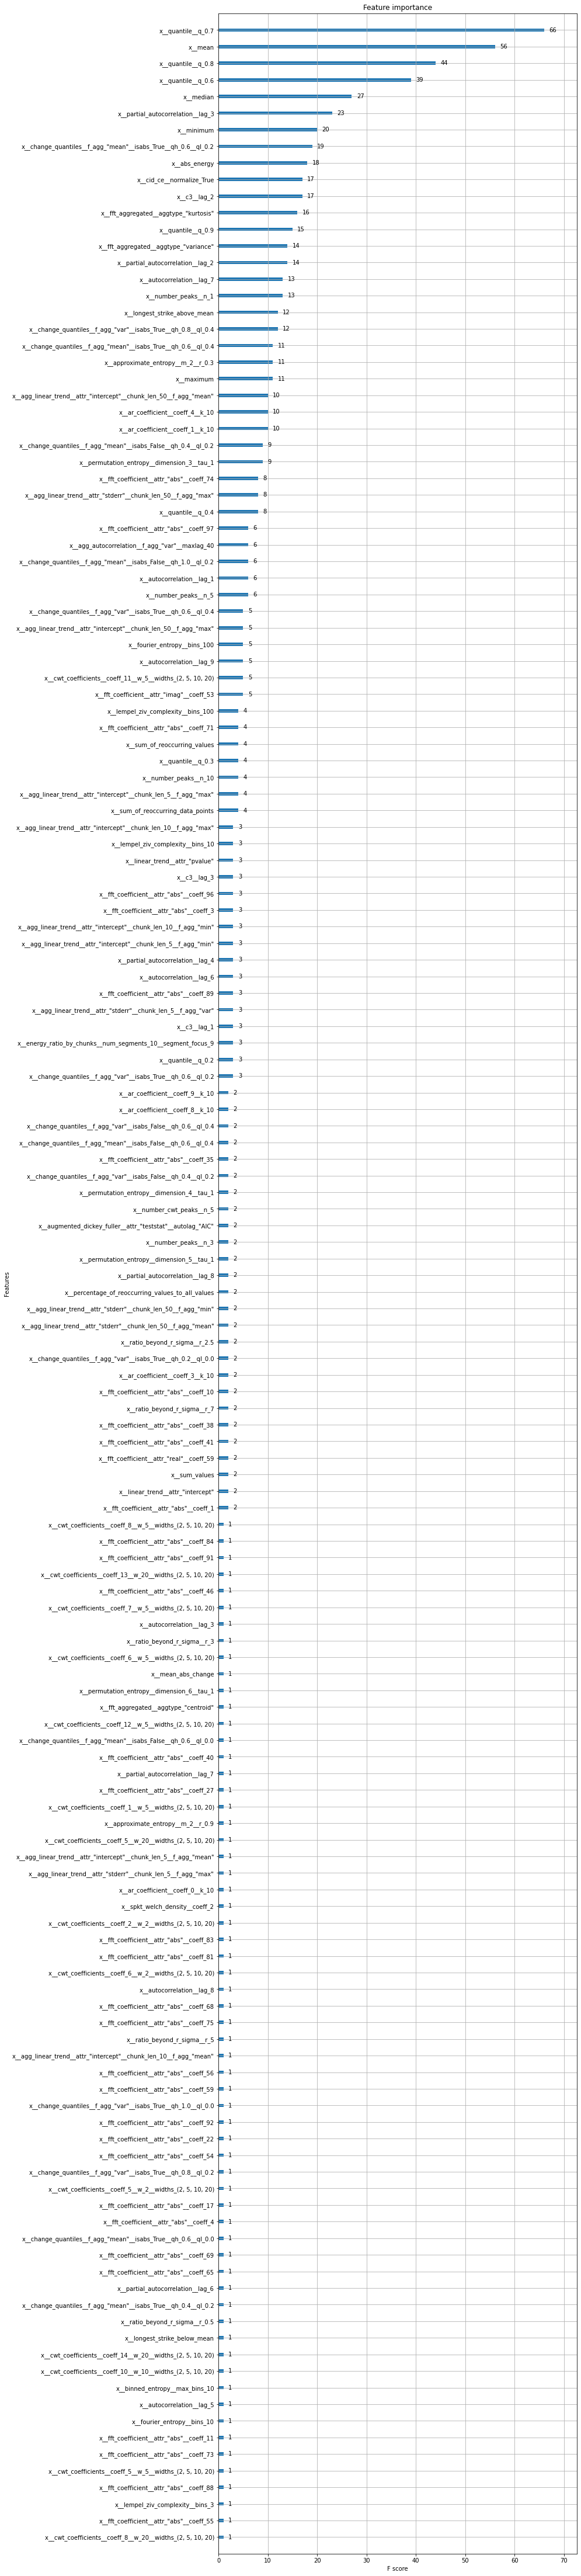

In [10]:
# Feature Importance and Feature Selection With XGBoost
# fit model no training data
model = XGBClassifier()
model.fit(X_filtered_train, y_train)
# feature importance
print(model.feature_importances_)

plot_importance(model)
fig = pyplot.gcf()
fig.set_size_inches(11,80)
pyplot.show()

In [11]:
for i in model.feature_importances_:
    selection = SelectFromModel(model, threshold=i, prefit=True)
    select_X_train = selection.transform(X_filtered_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_filtered_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%% " % (i, select_X_train.shape[1], accuracy*100.0))
    # print(selection)
    mask_array = selection.get_support(indices=False)
    reduced_feat = list()
    for j in range(len(mask_array)):
        if mask_array[j]:
            reduced_feat.append(X_filtered_train.columns[j])
            print(X_filtered_train.columns[j],model.feature_importances_[j])

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:46:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.061, n=4, Accuracy: 96.74% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.6 0.10288406
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.034, n=8, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:47:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.103, n=2, Accuracy: 95.65% 
x__quantile__q_0.6 0.10288406
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
[10:47:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.034, n=7, Accuracy: 98.19% 


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__quantile__q_0.7 0.060685933
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:47:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=57, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=139, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=103, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.049, n=6, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.6 0.10288406
x__c3__lag_2 0.04911618
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:47:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=118, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=71, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.010, n=21, Accuracy: 98.91% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__minimum 0.011379291
x__autocorrelation__lag_5 0.016161954
x__fft_coefficient__attr_"abs"__coeff_55 0.014027293
[10:47:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metr

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.003, n=42, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min" 0.0033012845
x__quantile__q_0.3 0.0044502
x__autocorrelation__lag_9 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.017, n=15, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=114, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=63, Accuracy: 97.10% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=74, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.023, n=11, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:47:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=142, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.004, n=35, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.3 0.0044502
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregate

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:47:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.052, n=5, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.6 0.10288406
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:47:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.020, n=13, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:47:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=101, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__cwt_coefficient

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__ff

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=55, Accuracy: 98.19% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20) 0.0020027764
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.002, n=60, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_

x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coef

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.009, n=22, Accuracy: 98.91% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__minimum 0.011379291
x__autocorrelation__lag_5 0.016161954
x__fft_coefficient__attr_"abs"__coeff_55 0.014027293
[10:47:38] WARNING: ../src/learner.cc:1061: Starting

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__a

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=94, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=123, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_

x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__a

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.180, n=1, Accuracy: 41.67% 
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"_

x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coe

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:48:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:48:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, th

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.003, n=44, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond

x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:48:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.004, n=33, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.3 0.0044502
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:48:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=145, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:48:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_c

x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"ab

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=52, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20) 0.0020027764
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:48:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.004, n=34, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quanti

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:48:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x

x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:48:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, th

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.014, n=18, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__autocorrelation__lag_5 0.016161954
x__fft_coefficient__attr_"abs"__coeff_55 0.014027293
[10:49:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set ev

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:49:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond

x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:49:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:49:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=46, Accuracy: 98.19% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20) 0

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=126, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=49, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20) 0

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__ag

x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond_r_sigma__r_1.5 0.0
x__fft_coefficient__attr_

x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:49:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=91, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=109, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=108, Accuracy: 98.19% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_

x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__a

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__large_standard_deviation__r_0.1 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0 0.0
x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717

x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__auto

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=137, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0 0.0
x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__ch

x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__auto

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__auto

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=152, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=86, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__percentage_of_reoccurring_datapoints_to_all_datapoints 0.0
x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__c

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"ab

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.003, n=36, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min" 0.0033012845
x__quantile__q_0.3 0.0044502
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelatio

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=110, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=59, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=76, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=131, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=78, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partia

x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coef

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=135, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coef

x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__ff

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=106, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"_

x__fft_coefficient__attr_"abs"__coeff_37 0.0
x__percentage_of_reoccurring_datapoints_to_all_datapoints 0.0
x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__a

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.002, n=62, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=85, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=68, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coef

x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=133, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.02271

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:52:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:52:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=95, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__cwt_coefficients__coeff_14__w_20__widths_(2,

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coe

x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:52:48

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:52:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=125, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coef

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:53:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond

x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:53:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_ag

x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__ff

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=89, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:53:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=80, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=97, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__cwt_coefficients__coeff_14__w_20__widths_(2,

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=88, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.3 0.0044502
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:53:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=53, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20) 0.0020027764
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:53:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=113, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=98, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__cwt_coefficients__coeff_14__w_20__widths_(2,

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:54:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min" 0.0033012845
x__quantile__q_0.3 0.0044502
x__autocorrelation__lag_9 0.0031044786
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelati

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
[10:54:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=67, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__chang

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__ar_coefficient__coeff_6__k_10 0.0
[10:54:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_

x__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0 0.0
x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__ch

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=102, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__cwt_coefficient

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__auto

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:54:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=117, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=48, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20) 0

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:54:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.022, n=12, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:54:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.031, n=9, Accuracy: 98.55% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:54:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x

x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=112, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__minimum 0.011379291
x__autocorrelation__lag_5 0.016161954
x__cid_ce__normalize_True 0.0069531472
x__fft_coefficient__attr_"abs"__coeff_55 0.014027293
[10:55:08]

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=56, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20) 0.0020027764
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__i

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=132, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.006, n=27, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entro

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.006, n=26, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__minimum 0.01

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.003, n=43, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min" 0.0033012845
x__quantile__q_0.3 0.0044502
x__autocorrelation__lag_9 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partia

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:55:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__ag

x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coe

x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:55:56

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:56:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_

x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__auto

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:56:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=92, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=51, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20) 0

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=124, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:56:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__auto

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=140, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__autocorrelation__lag_5 0.016161954
x__fft_coefficient__attr_"abs"__coeff_55 0.014027293


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:57:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_

x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__att

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:57:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=141, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:57:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0 0.0
x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__ch

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=143, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__ag

x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=96, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__cwt_coefficients__coeff_14__w_20__widths_(2,

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=93, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__i

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=138, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:57:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__spkt_welch_density__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_42 0.0
x__fft_coefficient__attr_"abs"__coeff_32 0.0
x__fft_coefficient__attr_"abs"__coeff_37 0.0
x__percentage_of_reoccurring_datapoints_to_all_datapoints 0.0
x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__c

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_

x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond

x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:58:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=151, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.009, n=23, Accuracy: 98.55% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__minimum 0.011379291
x__autocorrelation__lag_5 0.016161954
x__fft_coefficient__attr_"abs"__coeff_55 0.014027293

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff

x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=144, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[10:58:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond

x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_c

x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.065, n=3, Accuracy: 96.38% 
x__quantile__q_0.6 0.10288406
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
[10:59:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=87, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=65, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=50, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20) 0

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__a

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.003, n=39, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partia

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff

x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__i

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=136, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=70, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.002, n=47, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coe

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=148, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__ag

x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:00:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=104, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__a

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.004, n=31, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.3 0.0044502
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:00:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.019, n=14, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:00:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.011, n=20, Accuracy: 98.91% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:00:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__ag

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=90, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__autocorrelation__lag_5 0.016161954
[11:00:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.003, n=41, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min" 0.0033012845
x__quantile__q_0.3 0.0044502
x__autocorrelation__lag_9 0.0031044786
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_1

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=79, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=150, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:00:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:00:58

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=61, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:00:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=134, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.02271

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partia

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:01:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coe

x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:01:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.007, n=24, Accuracy: 98.91% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__minimum 0.011379291
x__autocorrelation__lag_5 0.016161954
x__cid_ce__normalize_True 0.0069531472
x__fft_coeffi

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond

x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:01:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__fft_coefficient__attr_"abs"__coeff_32 0.0
x__fft_coefficient__attr_"abs"__coeff_37 0.0
x__percentage_of_reoccurring_datapoints_to_all_datapoints 0.0
x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__att

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:01:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=83, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:01:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=73, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__i

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__ag

x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=66, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:01:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff

x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__i

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=122, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__ag

x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:02:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'm

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=81, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:02:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__a

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=146, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=72, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:02:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=99, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_ag

x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:02:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, th

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coef

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partia

x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"ab

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:02:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff

x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__i

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=84, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=69, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__i

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:03:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=75, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coe

x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.004, n=32, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.3 0.0044502
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:03:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:03:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, th

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"ab

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x

x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:03:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"_

x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__auto

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:03:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__att

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=100, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__cwt_coefficients__coeff_14__w_20__widths_(2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.014, n=17, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765
x__fourier_entropy__bins_10 0.019403607
x__autocorrelation__lag_5 0.016161954
x__fft_coefficient__attr_"abs"__coeff_55 0.014027293
[11:03:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_

x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"ab

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=147, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=127, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:04:15

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=54, Accuracy: 98.19% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20) 0.0020027764
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=119, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__a

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"_

x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=120, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.02271

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=128, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=129, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.02271

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coe

x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:04:42

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0

x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.004, n=30, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.3 0.0044502
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__fft_coefficient__attr_"abs"__coeff_11 0.008685438
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=107, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=82, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:05:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_ag

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:05:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=111, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:05:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:05:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20) 0.0
x__autocorrelation__lag_8 0.00037543572
x__binned_entropy__max_bins_10 0.0023156176
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__ch

x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=64, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:05:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coef

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:05:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__ff

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:05:57

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coef

x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"ab

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:06:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_

x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__ff

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=105, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:06:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"ab

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__i

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"ab

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.003, n=45, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"r

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=116, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:07:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.002, n=58, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4 0.0025990363
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coe

x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:07:38

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=149, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=130, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.004, n=28, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_10 0.030554952
x__partial_autocorrelation__lag_3 0.0063454513
x__autocorrelation__lag_7 0.005

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__ar_coefficient__coeff_1__k_10 0.030554952
x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_

x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__att

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0
[11:07:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.003, n=38, Accuracy: 97.46% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min" 0.0033012845
x__quantile__q_0.3 0.0044502
x__autocorrelation__lag_9 0.0031044786
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_1

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.001, n=77, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2 0.0019079202
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 0.0016550628
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=115, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_values 0.00056578754
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=121, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.02271

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__ff

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__auto

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coef

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_line

x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__ff

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficient

x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.000991

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.003, n=40, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__abs_energy 0.009628265
x__number_peaks__n_1 0.016625404
x__median 0.022717014
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4 0.019855842
x__sum_of_reoccurring_data_points 0.008815281
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20) 0.0039348025
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4 0.003750856
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2 0.013603487
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min" 0.0033012845
x__quantile__q_0.3 0.0044502
x__autocorrelation__lag_9 0.0031044786
x__quantile__q_0.2 0.021635719
x__ar_coefficient__coeff_1__k_1

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.00

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x__fft_coefficient__attr_"abs"__coeff_88 0.012504212
x__ratio_beyond

x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins_2 0.0
x__ar_coefficient__coeff_6__k_10 0.0


/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:08:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__c

x__fft_coefficient__attr_"abs"__coeff_29 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2 0.00050140894
x__fft_coefficient__attr_"abs"__coeff_43 0.0
x__fft_coefficient__attr_"abs"__coeff_50 0.0
x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coef

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:09:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.

x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coeffic

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_

x__symmetry_looking__r_0.1 0.0
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4 0.0
x__fft_coefficient__attr_"abs"__coeff_49 0.0
x__autocorrelation__lag_2 0.0
x__fft_coefficient__attr_"abs"__coeff_31 0.0
x__max_langevin_fixed_point__m_3__r_30 0.0
x__fft_coefficient__attr_"abs"__coeff_33 0.0
x__fft_coefficient__attr_"imag"__coeff_53 0.0025291063
x__approximate_entropy__m_2__r_0.7 0.0
x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__variance 0.0
x__standard_deviation 0.0
x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) 0.00043646476
x__partial_autocorrelation__lag_3 0.0063454513
x__longest_strike_above_mean 0.0018231835
x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.0
x__linear_trend__attr_"stderr" 0.0
x__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0 0.00020767147
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.0
x__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.0
x__autocorrelation__lag_7 0.0055244784
x__fft_aggregated__aggtype_"kurtosis" 0.0061071618
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" 0.002600717
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min" 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9

x__sample_entropy 0.0
x__fft_coefficient__attr_"angle"__coeff_94 0.0
x__fft_coefficient__attr_"abs"__coeff_35 0.0003958851
x__fft_coefficient__attr_"abs"__coeff_39 0.0
x__fft_coefficient__attr_"abs"__coeff_51 0.0
x__fft_coefficient__attr_"abs"__coeff_41 0.0017451185
x__approximate_entropy__m_2__r_0.5 0.0
x__ar_coefficient__coeff_8__k_10 6.578866e-05
x__agg_autocorrelation__f_agg_"var"__maxlag_40 0.00021652208
x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__ff

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Thresh=0.000, n=359, Accuracy: 97.83% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.8 0.033595
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max" 0.0017484463
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max" 0.00011940682
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max" 0.0005301178
x__c3__lag_2 0.04911618
x__c3__lag_3 0.00033781462
x__c3__lag_1 0.0011893832
x__abs_energy 0.009628265
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" 0.002601
x__number_peaks__n_1 0.016625404
x__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean" 0.00043002586
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean" 0.0013992195
x__linear_trend__attr_"intercept" 0.0010915032
x__median 0.022717014
x__lempel_ziv_complexity__bins_100 0.000109581895
x__permutation_entropy__dimension_3__tau_1 0.003724172
x__partial_autocorrelation__lag_2 0.02759281
x__mean 0.052471176

x__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_95 0.0
x__fft_coefficient__attr_"abs"__coeff_8 0.0
x__fft_coefficient__attr_"abs"__coeff_9 0.0
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" 0.0
x__fft_coefficient__attr_"abs"__coeff_86 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min" 0.0
x__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20) 0.0
x__ratio_value_number_to_time_series_length 0.0
x__partial_autocorrelation__lag_4 0.0007069654
x__fft_coefficient__attr_"abs"__coeff_82 0.0
x__kurtosis 0.0
x__fft_coefficient__attr_"abs"__coeff_96 0.0020827663
x__ratio_beyond_r_sigma__r_3 0.00031194952
x__fft_coefficient__attr_"abs"__coeff_99 0.0
x__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" 0.0
x__number_peaks__n_50 0.0
x__fft_coefficient__attr_"abs"__coeff_90 0.0
x__fft_coefficient__attr_"abs"__coeff_84 0.00011448158
x__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8 0.0
x

x__fft_coefficient__attr_"abs"__coeff_38 0.004453308
x__energy_ratio_by_chunks__num_segments_10__segment_focus_0 0.0
x__fft_coefficient__attr_"abs"__coeff_47 0.0
x__fft_coefficient__attr_"real"__coeff_59 0.0030092523
x__energy_ratio_by_chunks__num_segments_10__segment_focus_9 0.0009915525
x__autocorrelation__lag_3 0.0003971977
x__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC" 0.0003304468
x__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC" 0.0
x__fft_coefficient__attr_"abs"__coeff_53 0.0
x__number_crossing_m__m_1 0.0
x__fft_coefficient__attr_"abs"__coeff_36 0.0
x__fft_coefficient__attr_"real"__coeff_26 0.0
x__fft_coefficient__attr_"abs"__coeff_34 0.0
x__lempel_ziv_complexity__bins_3 0.0028306146
x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2 0.0
x__fft_coefficient__attr_"imag"__coeff_94 0.0
x__range_count__max_1__min_-1 0.0
x__count_below__t_0 0.0
x__value_count__value_0 0.0
x__number_crossing_m__m_0 0.0
x__value_count__value_1 0.0
x__fourier_entropy__bins

## Feature Engineering : Selecting a threshold according to the accuracy observed above

We observe that with 7 features we are able to achieve an accuracy of 98.2% with a threshold of 0.034

In [15]:
# Use those 7 features to train our model
selection = SelectFromModel(model, threshold=0.034, prefit=True)
select_X_train = selection.transform(X_filtered_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_filtered_test)
y_pred = selection_model.predict(select_X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%% " % (0.034, select_X_train.shape[1], accuracy*100.0))
# print(selection)
mask_array = selection.get_support(indices=False)
reduced_feat = list()
for j in range(len(mask_array)):
    if mask_array[j]:
        reduced_feat.append(X_filtered_train.columns[j])
        print(X_filtered_train.columns[j],model.feature_importances_[j])

/home/ak7/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:18:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.034, n=7, Accuracy: 98.19% 
x__quantile__q_0.7 0.060685933
x__quantile__q_0.6 0.10288406
x__quantile__q_0.9 0.034305826
x__c3__lag_2 0.04911618
x__mean 0.052471176
x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2 0.1802922
x__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.06508765


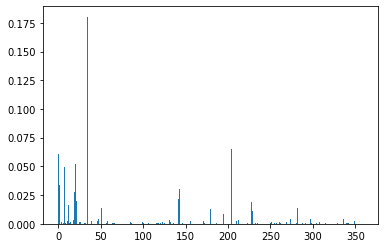

In [16]:
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:19:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


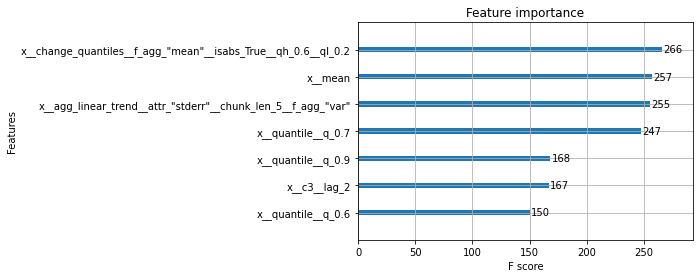

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        55
           1       0.96      0.98      0.97        55
           2       0.96      0.98      0.97        55
           3       1.00      1.00      1.00        56
           4       1.00      0.98      0.99        55

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



In [17]:
import shap

# load JS visualization code to notebook
shap.initjs()

W = X_filtered_train[reduced_feat]
U = X_filtered_test[reduced_feat]

model1 = XGBClassifier()
# use xgboost
# plot importance of decision tree
model1.fit(W, y_train)
plot_importance(model1)
pyplot.show()
print(classification_report(y_test, model1.predict(U)))

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(W)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], W.iloc[0,:])

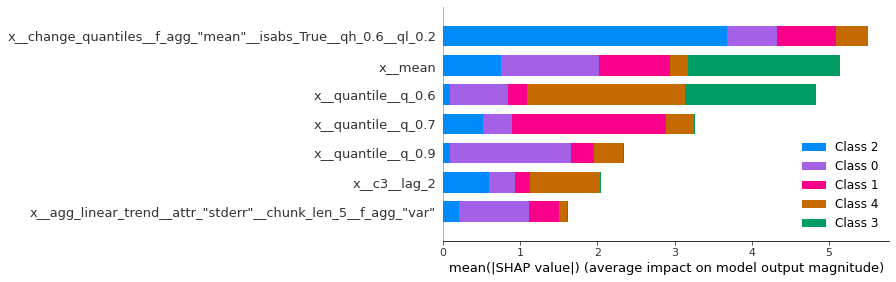

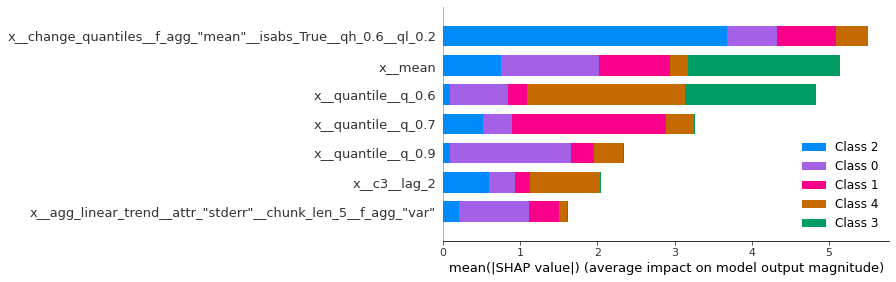

In [18]:
# summarize the effects of all the features
shap.summary_plot(shap_values, W)
shap.summary_plot(shap_values, W, plot_type="bar")

